In this notebook we will apply a support vector machine to build a model for predicting if a credit card will be paid back on due time or not. 

In [7]:
#First import some most common libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
%matplotlib inline

In [8]:
# Now import some modules for this problem specifically
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

In [31]:
data = pd.read_excel('default_of_credit_card_clients.xls', header = 1)

In [32]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [33]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [34]:
# Our target column is "default payment next month". Let's rename it
# Also 'ID' column is not useful. We can get rid of it
data.rename({'default payment next month' : 'Failed'}, axis = 1, inplace = True)
data.drop('ID', axis = 1, inplace = True)
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Failed'],
      dtype='object')

In [45]:
# Now we will check for some missing data or unusual data

print('List of unique values in Education column:', data['EDUCATION'].unique())
print('Number of N/A values in Education column:', data['EDUCATION'].isna().sum())

print('List of unique values in Marriage column:', data['MARRIAGE'].unique())
print('Number of N/A values in Marriage column:', data['MARRIAGE'].isna().sum())

List of unique values in Education column: [2 1 3 5 4 6 0]
Number of N/A values in Education column: 0
List of unique values in Marriage column: [1 2 3 0]
Number of N/A values in Marriage column: 0


Zeros in this columns does not have any meaning actually. So we can assume that these are missing data. Lets find out in where both Education and Marriage values are missing

In [56]:
print('Number of samples in original dataset:', len( data))
data_dropped = data.loc[(data['EDUCATION'] != 0) & (data['MARRIAGE'] != 0)]
print('Number of samples in data_dropped dataset:', len(data_dropped))

Number of samples in original dataset: 30000
Number of samples in data_dropped dataset: 29932


Now let's check again the zeros in those columns.

In [57]:
print('List of unique values in Education column:', data_dropped['EDUCATION'].unique())
print('Number of N/A values in Education column:', data_dropped['EDUCATION'].isna().sum())

print('List of unique values in Marriage column:', data_dropped['MARRIAGE'].unique())
print('Number of N/A values in Marriage column:', data_dropped['MARRIAGE'].isna().sum())

List of unique values in Education column: [2 1 3 5 4 6]
Number of N/A values in Education column: 0
List of unique values in Marriage column: [1 2 3]
Number of N/A values in Marriage column: 0


So there are not more zeros in those columns. It is interesting to observe that both of the columns had zeros for the same entries. Which proves our initial assumptions that zeros are actually missing values.

SVM works much better for smaller datasets rather than a large one. Our dataset has almost 30 Thousand datarows. So we will sample down with 1000 data from each target catagory.

In [61]:
data_failed = data[data['Failed'] == 1]
data_no_failed = data[data['Failed'] == 0]

data_failed_downsampled = resample(data_failed, replace = False,
                                  n_samples = 1000, random_state = 42)
data_no_failed_downsampled = resample(data_no_failed, replace = False,
                                  n_samples = 1000, random_state = 42)

In [63]:
# Now creating the final concatenated dataset from 1000 sample of each type
data_downsampled = pd.concat([data_failed_downsampled, data_no_failed_downsampled])

In [67]:
# Let's create the train test datasets and then split them

X = data_downsampled.drop('Failed', axis = 1)
y = data_downsampled['Failed']

We need to convert the categorical values by using One hot encoding

In [73]:
X_encoded = pd.get_dummies(X, columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

In [74]:
# We have to scale the data now
X_final = scale(X_encoded)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size = 0.2, random_state = 42)

In [77]:
# Now we will build our classifier

model_svm = SVC(random_state = 42)
model_svm.fit(X_train, y_train)

SVC(random_state=42)

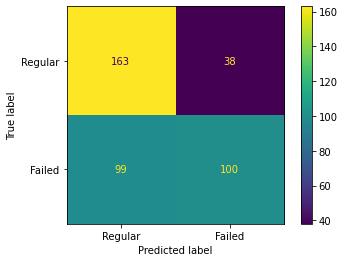

In [79]:
plot_confusion_matrix(model_svm, X_test, y_test, values_format = 'd',
                     display_labels = ['Regular', 'Failed'])

In our first attempt we tried with the default settings of Support Vector. Now we can use GridsearchCV to find the best parameters for the classifier.

In [94]:
parameters = [
    {
        'C' : [0.1, 0.5, 1, 5, 10],
        'gamma' : ['scale', 'auto', 1, 0.0001],
        'kernel' : ['rbf', 'poly']        
    },
]

optimized_parameters = GridSearchCV(SVC(), parameters, cv = 5, scoring = 'accuracy', verbose = 2) 
optimized_parameters.fit(X_train, y_train)
print(optimized_parameters.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.3s
[CV] C=0.1, gamma=scale, kernel=poly .................................
[CV] .................. C=0.1, gamma=scale, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=scale, kernel=poly .................................
[CV] .................. C=0.1, gamma=scale, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=scale, kernel=poly .................................
[CV] .................. C=0.1, gamma=scale, kernel=poly, total=   0.2s
[CV] C=0.1, gamma=scale, kernel=poly .................................
[CV] .

[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.5, gamma=1, kernel=rbf, total=   0.2s
[CV] C=0.5, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.5, gamma=1, kernel=poly, total=   1.1s
[CV] C=0.5, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.5, gamma=1, kernel=poly, total=   1.7s
[CV] C=0.5, gamma=1, kernel=poly .....................................
[CV] .

[CV] ................... C=1, gamma=0.0001, kernel=poly, total=   0.1s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV] ................... C=1, gamma=0.0001, kernel=poly, total=   0.1s
[CV] C=5, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=5, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=5, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=5, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.2s
[CV] C=5, gamma=scale, kernel=rbf ....................................
[CV] ..................... C=5, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=5, gamma=scale, kernel=poly ...................................
[CV] .

[CV] .................... C=10, gamma=auto, kernel=poly, total=   0.1s
[CV] C=10, gamma=auto, kernel=poly ...................................
[CV] .................... C=10, gamma=auto, kernel=poly, total=   0.1s
[CV] C=10, gamma=auto, kernel=poly ...................................
[CV] .................... C=10, gamma=auto, kernel=poly, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.2s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.2s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.2s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.2s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.1min finished


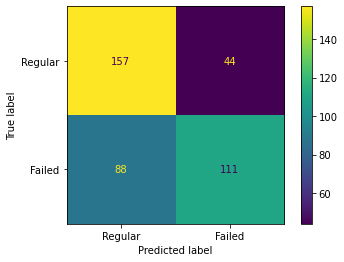

In [95]:
# We found C = 5, gamma = 'scale' and kernel = 'rbf' is the best parameter combination
# Let us make another optimized classifier using these parameters

optimized_model_svm = SVC(random_state = 42, C = 5, gamma = 'scale', kernel = 'rbf')
optimized_model_svm.fit(X_train, y_train)
plot_confusion_matrix(optimized_model_svm, X_test, y_test, values_format = 'd',
                     display_labels = ['Regular', 'Failed'])